In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy import stats
import time
from datetime import datetime

import sklearn

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from math import sqrt

# encode categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve


In [2]:
data= pd.read_csv('0301-0306.csv')
data.head()

C:\Users\anranzheng\AppData\Local\Temp\ipykernel_37340\3668088970.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv('0301-0306.csv')


,Unnamed: 0,interval2,interval2s,block_id,trip_id,route_id,route_short_name,direction_id,stop_id,stop_name,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon
0,0,6.466667,5.0,1403220.0,4828768.0,14456.0,MMO,0.0,795.0,School Board Metromover Station,...,353.0,1017.7,0.0,9.1,0.0,NaN,0.0,10.0,Clear,clear-night
1,1,6.466667,5.0,1403224.0,4828769.0,14456.0,MMO,0.0,795.0,School Board Metromover Station,...,353.0,1017.7,0.0,9.1,0.0,NaN,0.0,10.0,Clear,clear-night
2,2,11.733333,5.0,1403217.0,4828770.0,14456.0,MMO,0.0,795.0,School Board Metromover Station,...,353.0,1017.7,0.0,9.1,0.0,NaN,0.0,10.0,Clear,clear-night
3,3,2.150000,0.0,1403224.0,4828769.0,14456.0,MMO,0.0,795.0,School Board Metromover Station,...,353.0,1017.7,0.0,9.1,0.0,NaN,0.0,10.0,Clear,clear-night
4,4,1.833333,5.0,1403221.0,4828771.0,14456.0,MMO,0.0,795.0,School Board Metromover Station,...,353.0,1017.7,0.0,9.1,0.0,NaN,0.0,10.0,Clear,clear-night


In [3]:
data.shape

(1288040, 45)

# Data cleaning

**Target:**

**sched_adherence_min**: this should be positive or negative (actual-schedule), positive - late, negative-early

**Predictors:**

interval2 (this is the time lag between two trips)

route_id, direction_id,  headsign, gtfs_stop_seq, wk

headway_diff (this is the difference between the actual and scheduled headway, another measurement of on-time performance)

date, timestamp (need process later), and weather (similar to the format of Jacksonville)

**Newly added predictors:**
- Transfer actual/schedule time stamp to minutes since 00:00


In [4]:
data.dtypes

Unnamed: 0                int64
interval2               float64
interval2s              float64
block_id                float64
trip_id                 float64
route_id                float64
route_short_name         object
direction_id            float64
stop_id                 float64
stop_name                object
headsign                 object
vehicle_id               object
gtfs_stop_seq           float64
start_time               object
sched_adherence_secs    float64
scheduled_date           object
scheduled_time           object
actual_date              object
actual_time              object
is_arrival                 bool
wk                       object
headway_diff            float64
status                   object
sched_adherence_min     float64
hr                      float64
datetime                 object
temp                    float64
feelslike               float64
dew                     float64
humidity                float64
precip                  float64
precippr

In [5]:
#split the timestamp by the :

data[['start_hr', 'start_min']] = data["start_time"].apply(lambda x: pd.Series(str(x).split(":")))
#replace with the corrected hours
#switch to timestamp and minus

data.start_hr[data.start_hr == '28'] = '04'
data.start_hr[data.start_hr == '24']   = '00'
data.start_hr[data.start_hr == '25'] = '01'
data.start_hr[data.start_hr == '26']   = '02'
data.start_hr[data.start_hr == '27']   = '03'
data.start_hr[data.start_hr == '29']   = '05'

#merge the start_hr and min
data ['start_time2'] = data[['start_hr', 'start_min']].apply(
    lambda x: ':'.join(x.dropna().astype(str)),
    axis=1
)

data['actual_total_sec']=pd.to_datetime(data ['actual_time']).dt.second+60*pd.to_datetime(data['actual_time']).dt.minute+3600*pd.to_datetime(data ['actual_time']).dt.hour

data['start_total_sec']=pd.to_datetime(data['start_time2']).dt.second+60*pd.to_datetime(data['start_time2']).dt.minute+3600*pd.to_datetime(data['start_time2']).dt.hour

data['driving_time']=(data['actual_total_sec']-data['start_total_sec'])/60

data['driving_time'].describe()

C:\Users\anranzheng\AppData\Local\Temp\ipykernel_37340\2741529032.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.start_hr[data.start_hr == '28'] = '04'
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_37340\2741529032.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.start_hr[data.start_hr == '24']   = '00'
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_37340\2741529032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

count    1.288040e+06
mean     3.465484e+01
std      9.876720e+01
min     -1.436817e+03
25%      1.760000e+01
50%      3.560000e+01
75%      5.883333e+01
max      1.439867e+03
Name: driving_time, dtype: float64

In [6]:
data['actual_total_hr']=data['actual_total_sec']/3600
data['sche_total_hr']=data['start_total_sec']/3660

In [7]:
data['driving_time'][data['driving_time']>=200]=data['driving_time']-1440
data['driving_time'][data['driving_time']<=-200]=data['driving_time']+1440
data['driving_time'].describe()
#this should be driving time +1440(24*60)

C:\Users\anranzheng\AppData\Local\Temp\ipykernel_37340\1973210445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['driving_time'][data['driving_time']>=200]=data['driving_time']-1440
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_37340\1973210445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['driving_time'][data['driving_time']<=-200]=data['driving_time']+1440


count    1.288040e+06
mean     4.093228e+01
std      2.863711e+01
min     -2.006667e+01
25%      1.788333e+01
50%      3.585000e+01
75%      5.901667e+01
max      1.911667e+02
Name: driving_time, dtype: float64

In [8]:
list1=['9','132','54']
data=data[data['route_short_name'].isin(list1)]

In [9]:
data.hr.unique()

array([ 5.,  6.,  7.,  8., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
       19., 20., 21., 22.,  9., 23.,  0.,  4.])

In [10]:

def categorize_time(x):
    if 6<=x<=8 :
        return 'morning peak'
    if 16<=x<=19:
        return 'evening peak'
    else:
        return 'off peak'

data['period'] = data['hr'].apply(categorize_time)

In [11]:
data2=data.drop(['actual_date','stop_id','vehicle_id','block_id', 'trip_id','Unnamed: 0','interval2s','route_id','stop_name','start_time','sched_adherence_secs','scheduled_date', 'scheduled_time','actual_time', 'is_arrival','status','datetime','preciptype','start_hr','start_min','start_time2','actual_total_sec','start_total_sec','precipprob','precip','hr','headsign'],axis=1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59028 entries, 1350 to 1275869
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   interval2            59028 non-null  float64
 1   route_short_name     59028 non-null  object 
 2   direction_id         59028 non-null  float64
 3   gtfs_stop_seq        59028 non-null  float64
 4   wk                   59028 non-null  object 
 5   headway_diff         59028 non-null  float64
 6   sched_adherence_min  59028 non-null  float64
 7   temp                 59028 non-null  float64
 8   feelslike            59028 non-null  float64
 9   dew                  59028 non-null  float64
 10  humidity             59028 non-null  float64
 11  windgust             59028 non-null  float64
 12  windspeed            59028 non-null  float64
 13  winddir              59028 non-null  float64
 14  sealevelpressure     59028 non-null  float64
 15  cloudcover           59028 non-

In [12]:
# check to see what percentage of data will be lost if all null values are dropped
(data2.isnull().sum()/data2.isnull().count()*100).astype(str)+" %"

interval2                             0.0 %
route_short_name                      0.0 %
direction_id                          0.0 %
gtfs_stop_seq                         0.0 %
wk                                    0.0 %
headway_diff                          0.0 %
sched_adherence_min                   0.0 %
temp                                  0.0 %
feelslike                             0.0 %
dew                                   0.0 %
humidity                              0.0 %
windgust                              0.0 %
windspeed                             0.0 %
winddir                               0.0 %
sealevelpressure                      0.0 %
cloudcover                            0.0 %
visibility                            0.0 %
solarradiation                        0.0 %
solarenergy            22.274174967811884 %
uvindex                               0.0 %
severerisk                            0.0 %
conditions                            0.0 %
icon                            

In [13]:
#full solar energy NAN with 0
data2['solarenergy'] = data2['solarenergy'].fillna(0)

# Exploratory Data Analysis

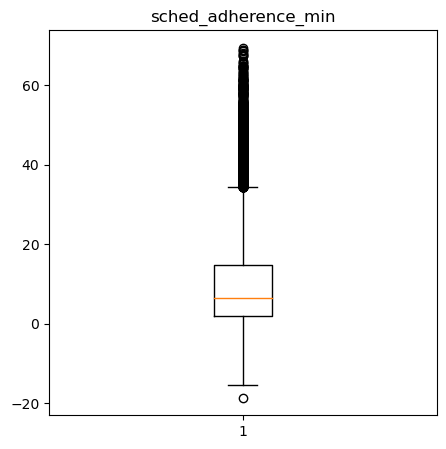

In [14]:
plt.figure(figsize=(5,5))
plt.boxplot(data2.sched_adherence_min)
plt.title('sched_adherence_min')
plt.show()

# Preprcessing and Feature Selection

In [15]:
data2.columns

Index(['interval2', 'route_short_name', 'direction_id', 'gtfs_stop_seq', 'wk',
       'headway_diff', 'sched_adherence_min', 'temp', 'feelslike', 'dew',
       'humidity', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk', 'conditions', 'icon', 'driving_time', 'actual_total_hr',
       'sche_total_hr', 'period'],
      dtype='object')

- switch the following categorical variables into dummy varaibles: 

'route_id', 'direction_id', 'actual_date', 'wk',conditions,'icon','headsign'

In [16]:
#category variables 
df_dummy = data2[['route_short_name', 'period', 'wk','conditions','icon']]
df_dummy=pd.get_dummies(df_dummy)
data2=data2.drop(['route_short_name', 'period', 'wk','conditions','icon'],axis='columns')

pd.get_dummies(df_dummy).columns

df_dummy

,route_short_name_132,route_short_name_54,route_short_name_9,period_evening peak,period_morning peak,period_off peak,wk_Weekday,wk_Weekend,conditions_Clear,conditions_Overcast,conditions_Partially cloudy,icon_clear-day,icon_clear-night,icon_cloudy,icon_partly-cloudy-day,icon_partly-cloudy-night
1350,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0
1351,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0
1352,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0
1353,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0
1354,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275865,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
1275866,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
1275867,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
1275868,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0


In [17]:
data2=pd.concat([data2,df_dummy],axis=1)
data2.head()

,interval2,direction_id,gtfs_stop_seq,headway_diff,sched_adherence_min,temp,feelslike,dew,humidity,windgust,...,wk_Weekday,wk_Weekend,conditions_Clear,conditions_Overcast,conditions_Partially cloudy,icon_clear-day,icon_clear-night,icon_cloudy,icon_partly-cloudy-day,icon_partly-cloudy-night
1350,49.750000,0.0,69.0,-4.800000,6.300000,63.9,63.9,61.4,91.38,5.8,...,1,0,1,0,0,0,1,0,0,0
1351,39.000000,0.0,43.0,6.000000,8.948400,63.9,63.9,61.4,91.38,5.8,...,1,0,1,0,0,0,1,0,0,0
1352,39.000000,0.0,43.0,6.000000,14.933333,63.9,63.9,61.4,91.38,5.8,...,1,0,1,0,0,0,1,0,0,0
1353,37.000000,1.0,27.0,-1.183333,5.550000,63.9,63.9,61.4,91.38,5.8,...,1,0,1,0,0,0,1,0,0,0
1354,33.966667,1.0,1.0,-3.033333,-0.759350,63.9,63.9,61.4,91.38,5.8,...,1,0,1,0,0,0,1,0,0,0


take a look at the heatmap of the correlation matrix to see if any features are highly correlated. If so Well drop one of the correlated features and keep the one that is most highly correlated with the target.

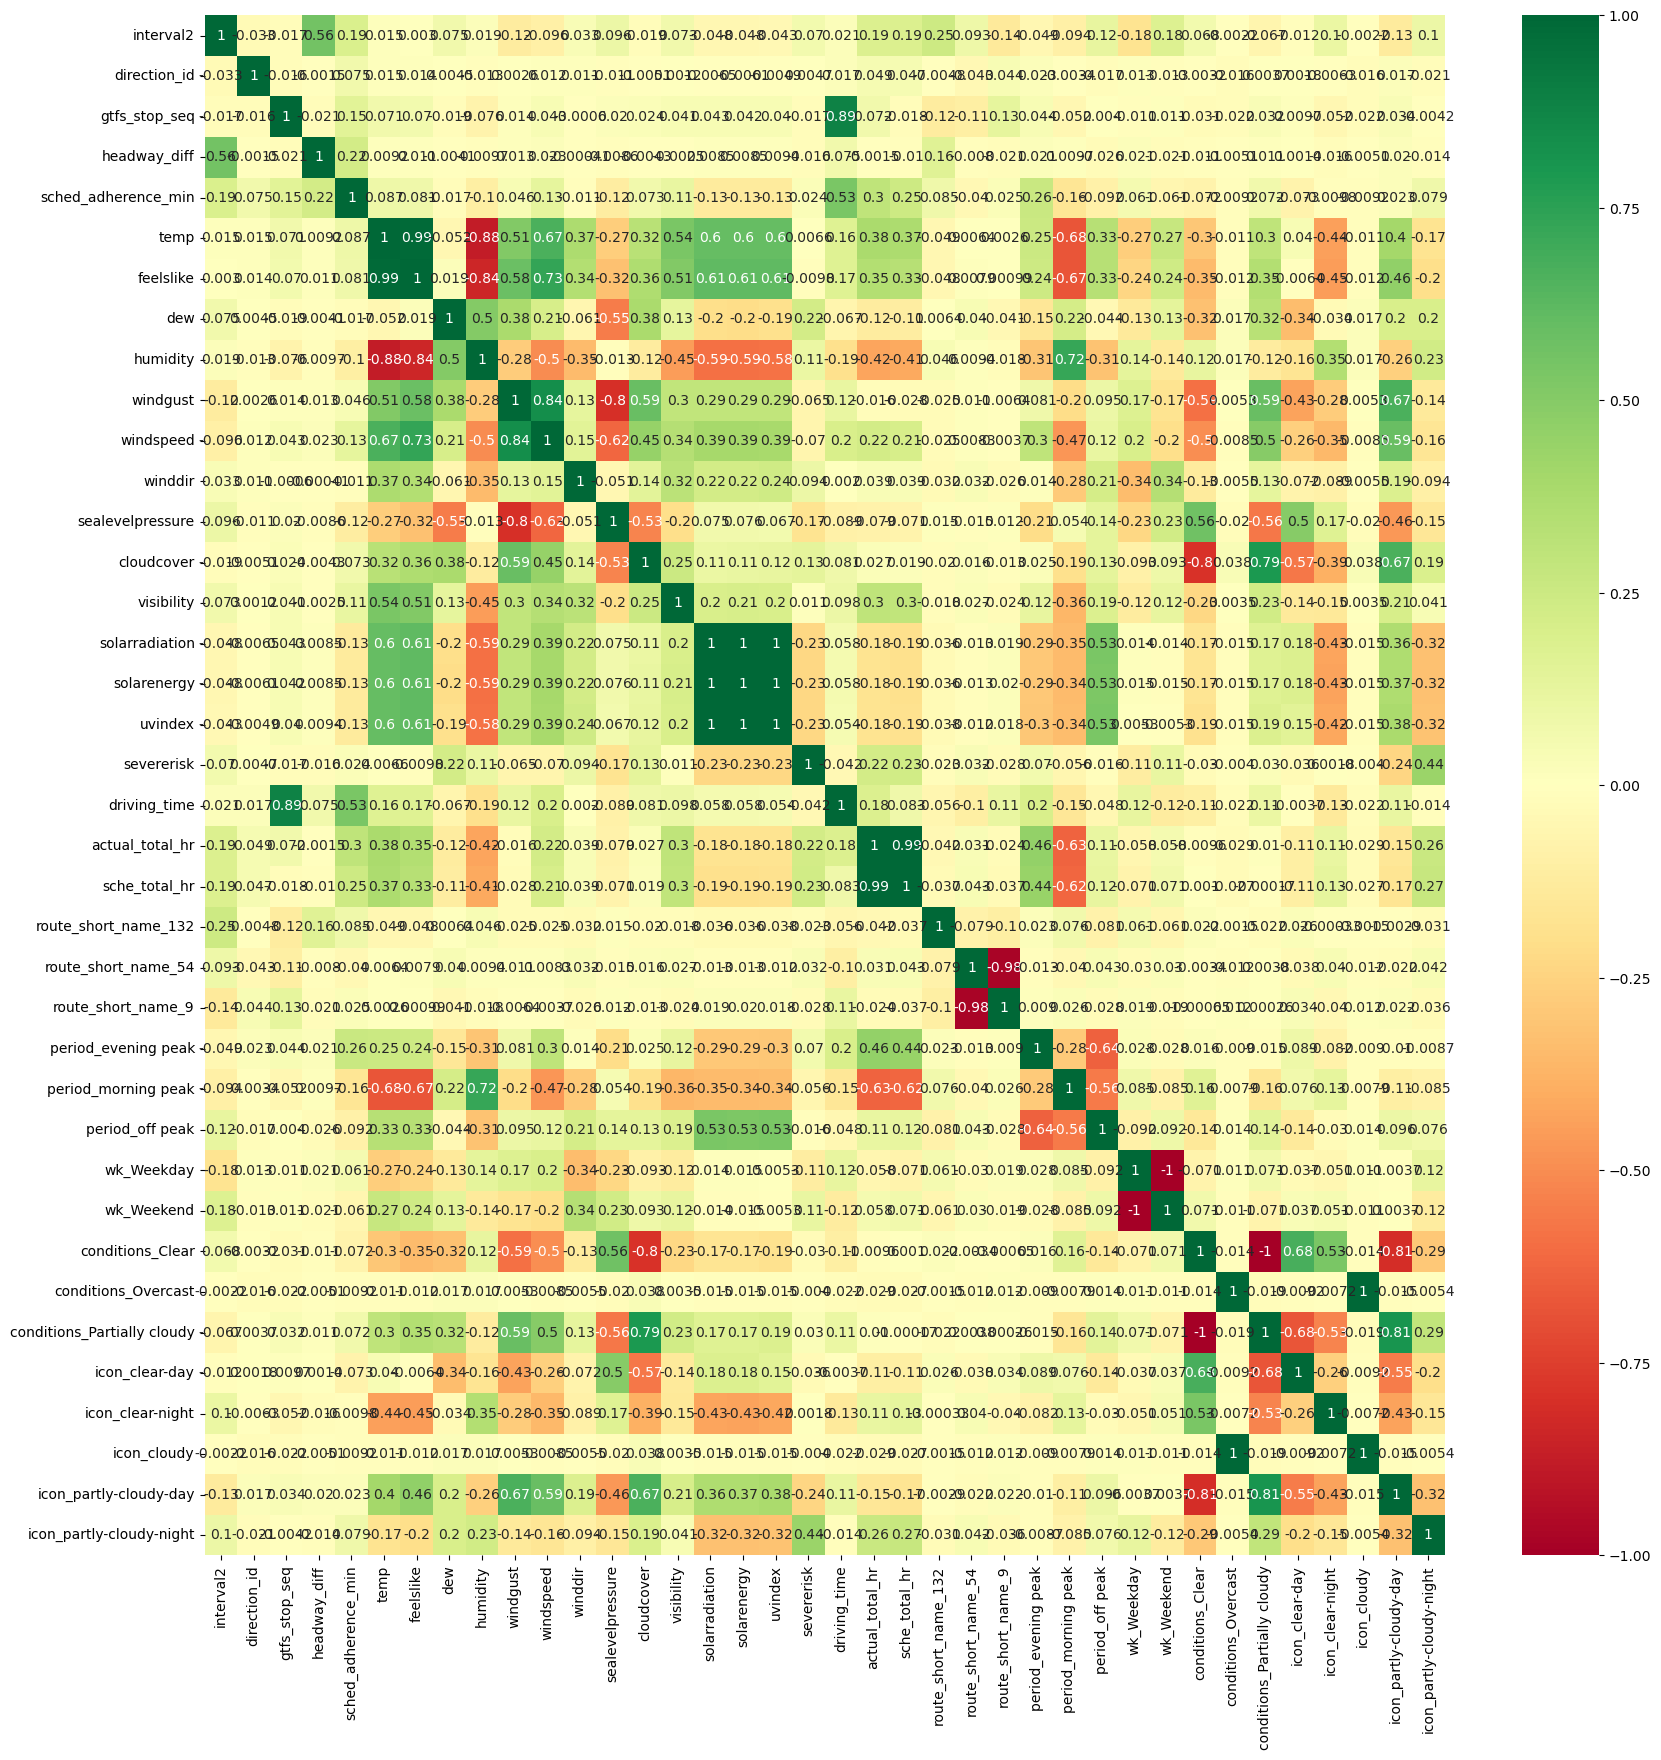

In [18]:
#get correlations of each features in dataset
corrmat = data2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data2[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [19]:
columns = np.full((corrmat.shape[0],), True, dtype=bool)
for i in range(corrmat.shape[0]):
    for j in range(i+1, corrmat.shape[0]):
        if corrmat.iloc[i,j] >= 0.5 or corrmat.iloc[i,j]<=-0.5:
            if columns[j]:
                columns[j] = False

In [20]:
selected_columns=data2.columns[columns]
data2 = data2[selected_columns]

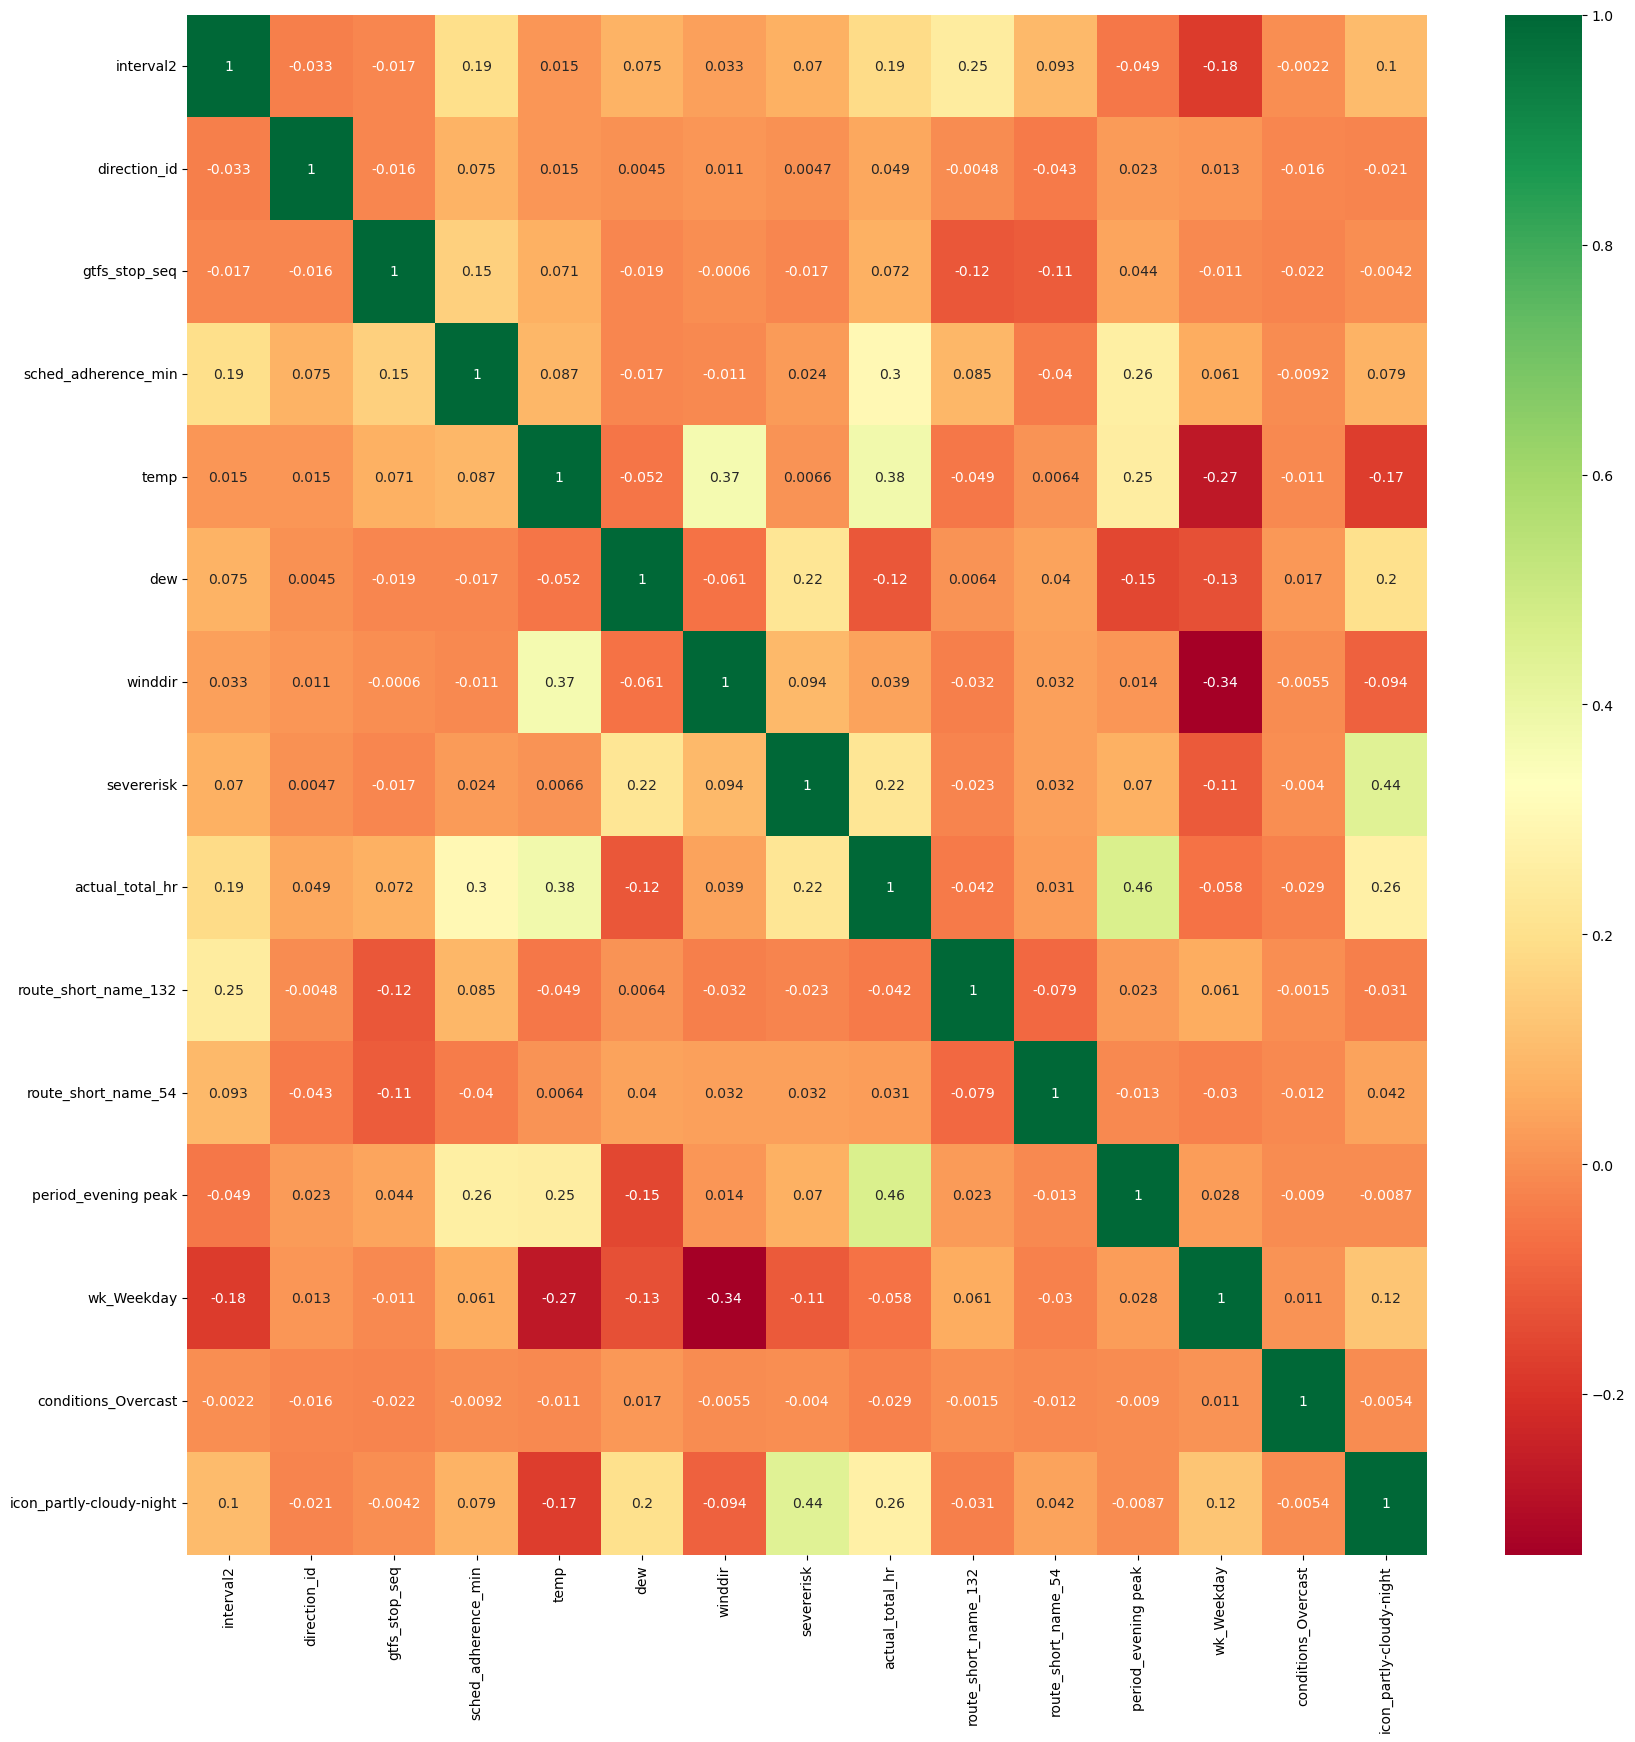

In [21]:
#low correlation 
corrmat = data2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data2[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [22]:
y=data2.sched_adherence_min
x=data2.drop('sched_adherence_min',1)
x.shape
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.3, random_state=1)

C:\Users\anranzheng\AppData\Local\Temp\ipykernel_37340\586541078.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x=data2.drop('sched_adherence_min',1)


In [23]:
print(X_train.shape) 
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(41319, 14)
(41319,)
(17709, 14)
(17709,)


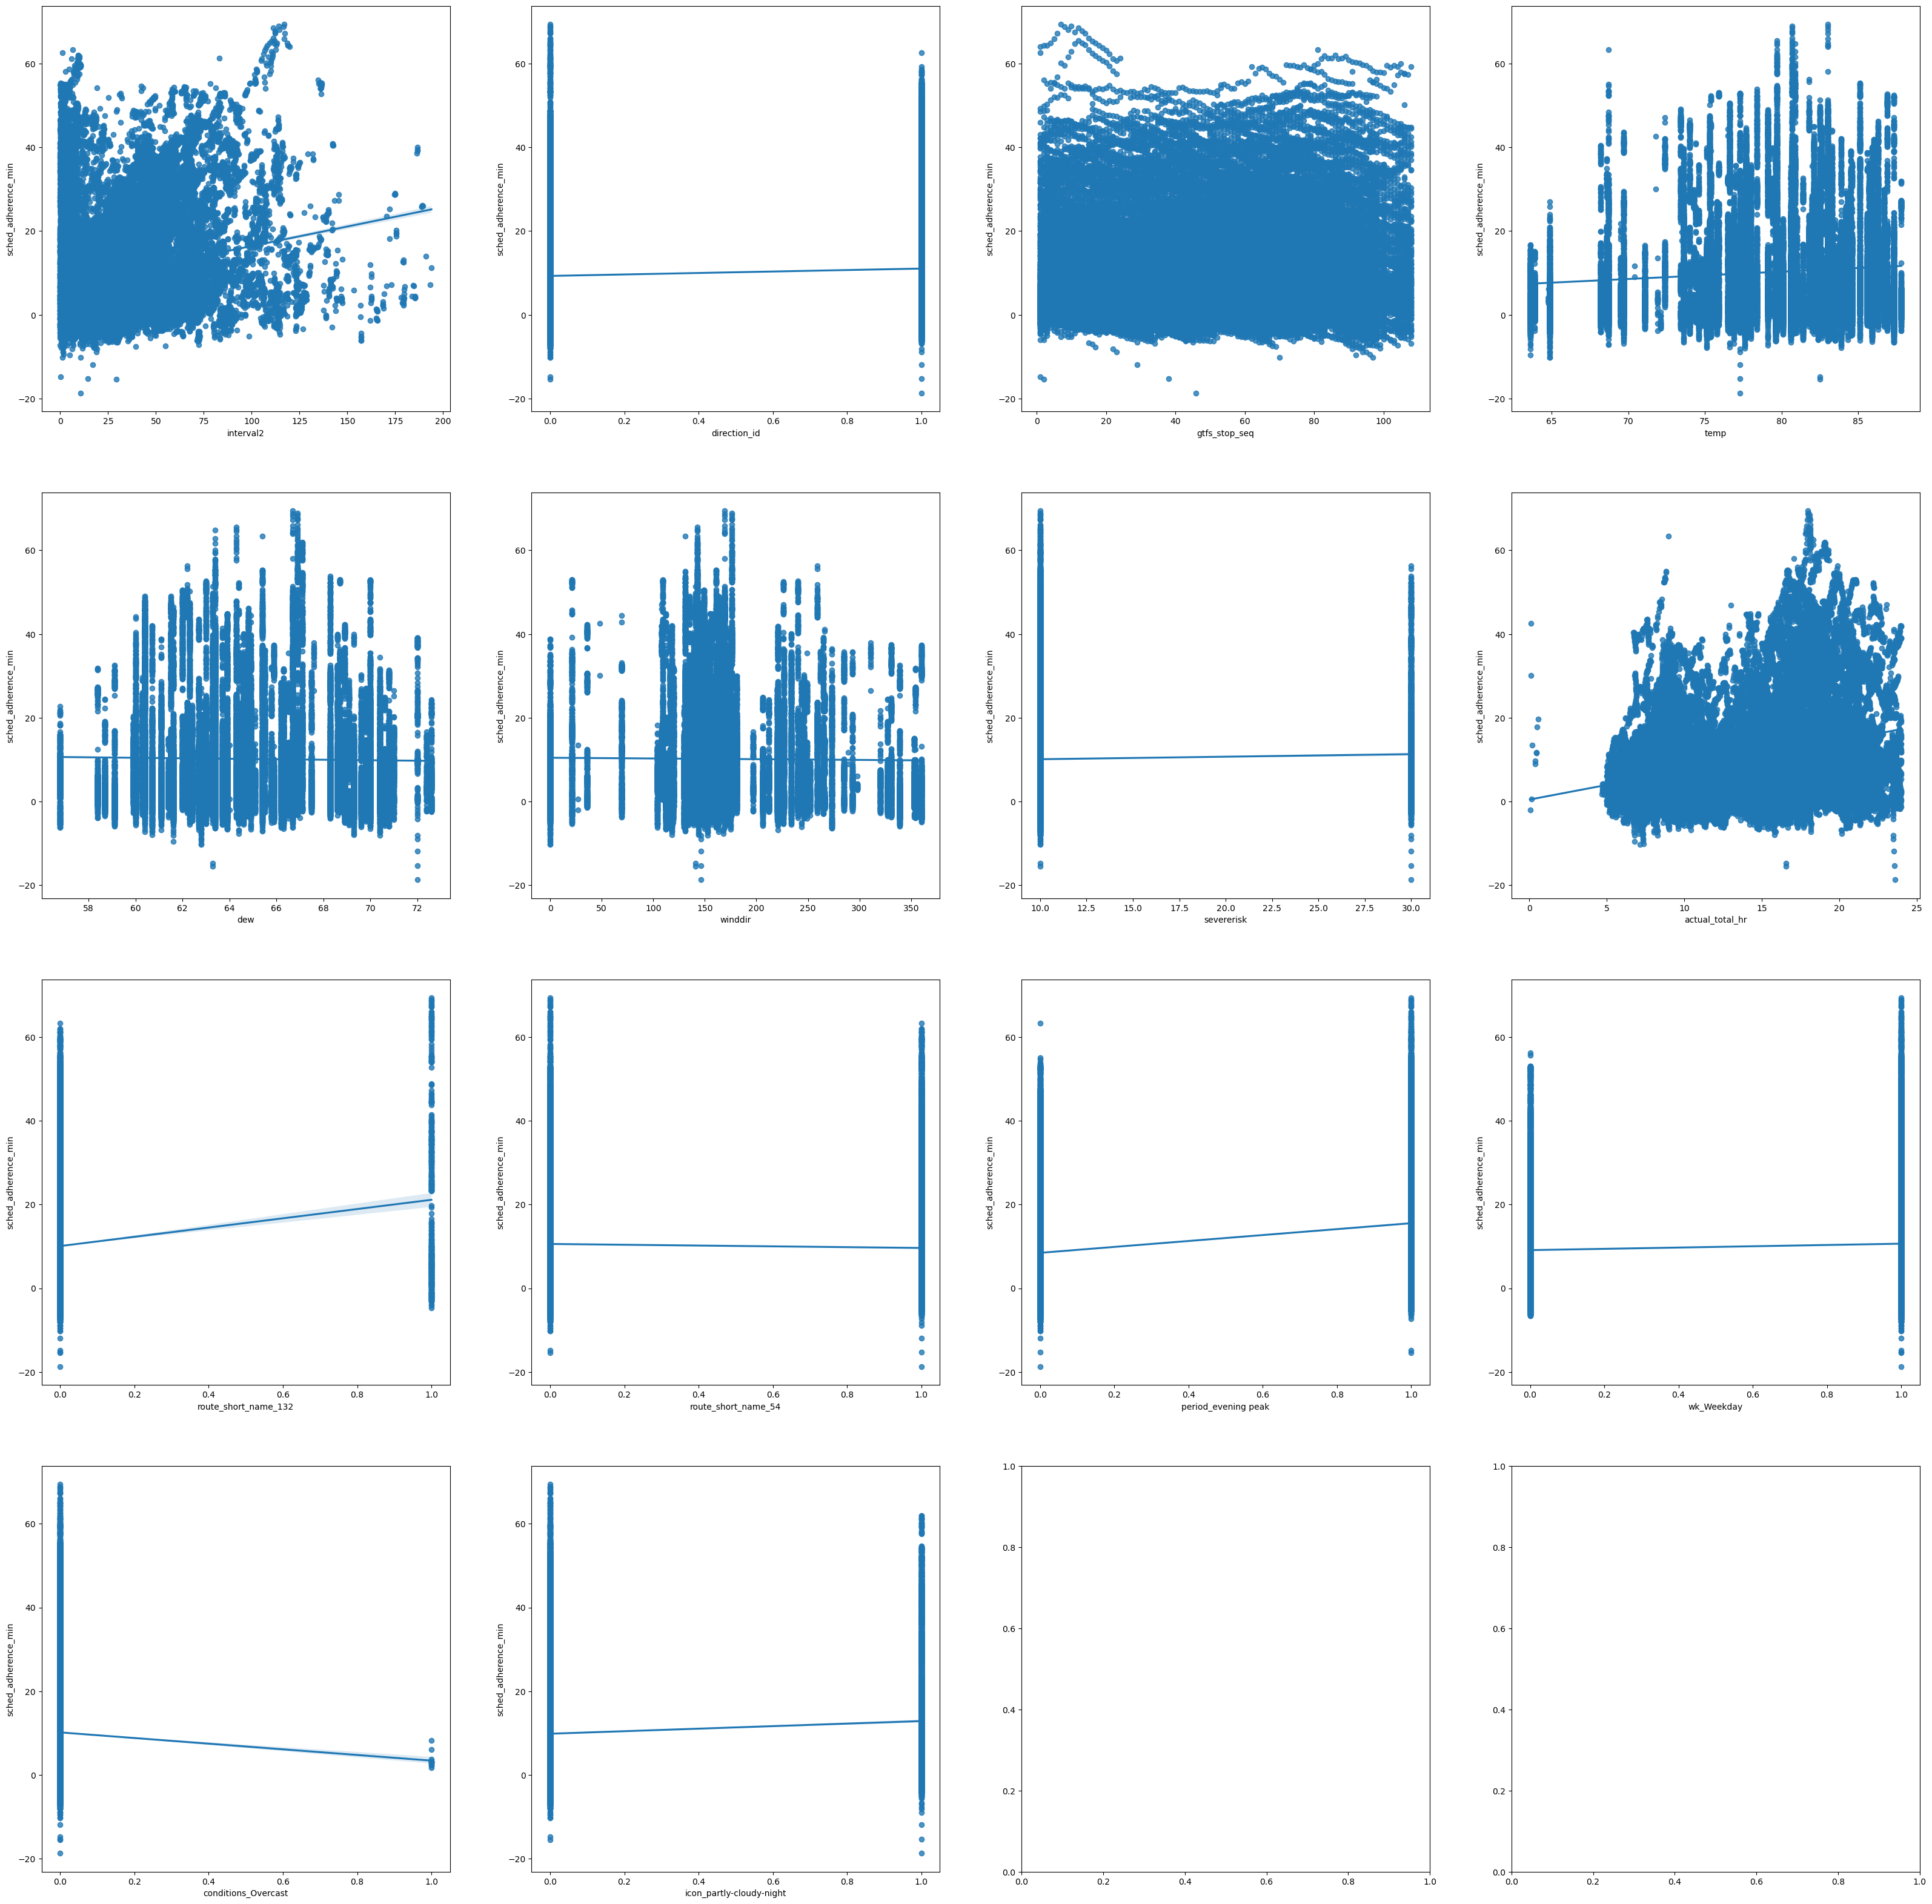

In [24]:
#linear relationship
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(40, 40))
index = 0
axs = axs.flatten()
for i, k in enumerate(x.columns):
    sns.regplot(y=y, x=x[k], ax=axs[i])

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

# Basic ML models 

In [25]:
# scale the data
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()
sclr.fit(X_train)
X_train = sclr.transform(X_train)
X_test = sclr.transform(X_test)

### random forest

In [26]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
reg = RandomForestRegressor()

# Train the model using the training sets 
reg.fit(X_train, Y_train)

y_pred = reg.predict(X_train)

# Model Evaluation
from sklearn import metrics

print('R^2:',metrics.r2_score(Y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_train, y_pred))*(len(Y_train)-1)/(len(Y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_train, y_pred))
print('MSE:',metrics.mean_squared_error(Y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_train, y_pred)))

R^2: 0.9816744943614771
Adjusted R^2: 0.9816682829272592
MAE: 0.6910971676428116
MSE: 2.5155549484396365
RMSE: 1.5860501090569732


In [27]:
y_test_pred = reg.predict(X_test)

acc_rf = metrics.r2_score(Y_test, y_test_pred)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_test, y_test_pred))*(len(Y_test)-1)/(len(Y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(Y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_test, y_test_pred)))

R^2: 0.8585607979094312
Adjusted R^2: 0.8584488871583704
MAE: 1.912223624371788
MSE: 19.26370350207461
RMSE: 4.389043574866238


In [29]:
reg.feature_importances_

array([2.65812258e-01, 4.38464688e-02, 1.21780240e-01, 5.84421221e-02,
       6.50651324e-02, 6.26636665e-02, 3.40315546e-03, 2.80964292e-01,
       1.22085047e-02, 5.11292437e-02, 2.75933442e-03, 2.60387093e-02,
       1.26674834e-06, 5.88560555e-03])

In [30]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

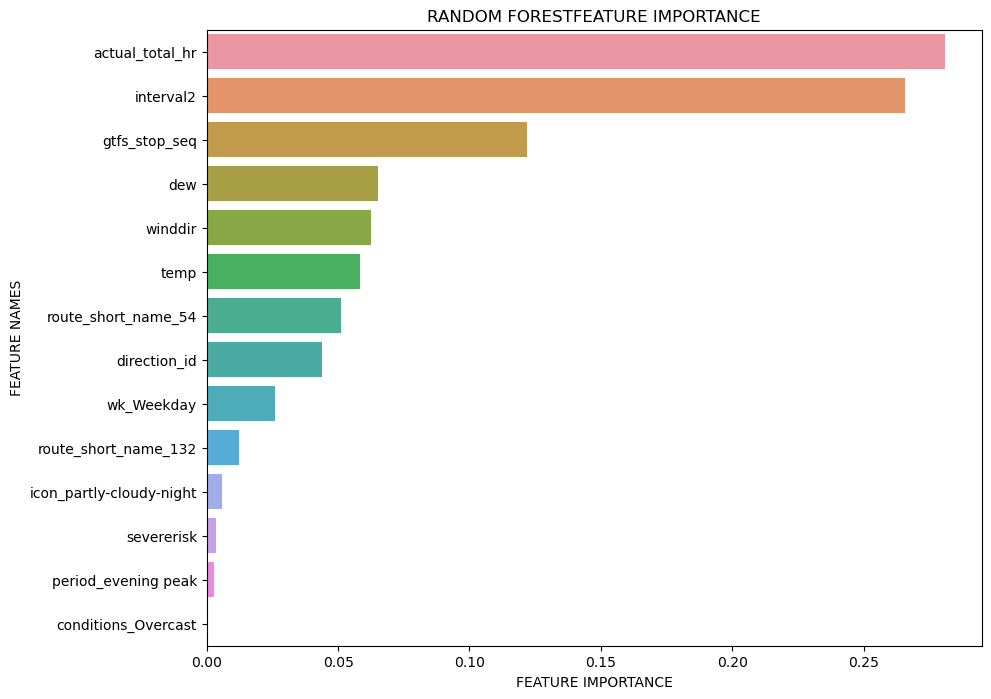

In [31]:
plot_feature_importance(reg.feature_importances_,x.columns,'RANDOM FOREST')

<BarContainer object of 14 artists>

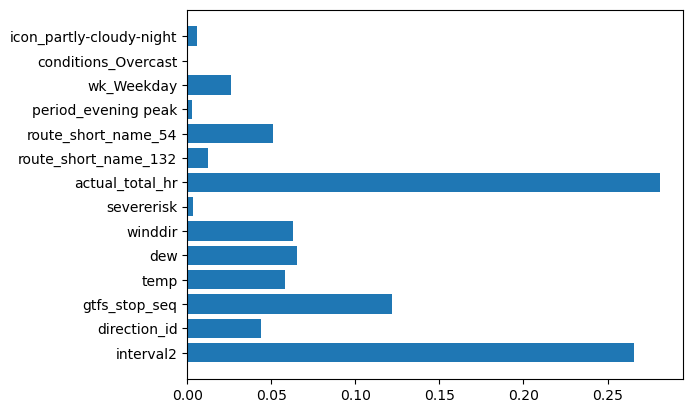

In [32]:
plt.barh(x.columns, reg.feature_importances_)

##  SVM

In [35]:
# Import SVM Regressor
from sklearn import svm

# Create a SVM Regressor
reg = svm.SVR()

# Train the model using the training sets 
reg.fit(X_train, Y_train)

# Model prediction on train data
y_pred = reg.predict(X_train)

# Model Evaluation
print('R^2:',metrics.r2_score(Y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_train, y_pred))*(len(Y_train)-1)/(len(Y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_train, y_pred))
print('MSE:',metrics.mean_squared_error(Y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_train, y_pred)))

R^2: 0.3459554812676736
Adjusted R^2: 0.34573379273236826
MAE: 6.194382560783921
MSE: 89.78114754652655
RMSE: 9.47529142277569


In [36]:
y_test_pred = reg.predict(X_test)

acc_rf = metrics.r2_score(Y_test, y_test_pred)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_test, y_test_pred))*(len(Y_test)-1)/(len(Y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(Y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_test, y_test_pred)))

R^2: 0.3314582713723653
Adjusted R^2: 0.3309293019928702
MAE: 6.261062090839417
MSE: 91.05389063776352
RMSE: 9.542216233022783


## Decision tree

In [37]:
from sklearn.tree import DecisionTreeRegressor
# Model Evaluation
from sklearn import metrics
reg = DecisionTreeRegressor()

# Train the model using the training sets 
reg.fit(X_train, Y_train)

y_pred = reg.predict(X_train)

# Model Evaluation
print('R^2:',metrics.r2_score(Y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_train, y_pred))*(len(Y_train)-1)/(len(Y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_train, y_pred))
print('MSE:',metrics.mean_squared_error(Y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_train, y_pred)))

R^2: 1.0
Adjusted R^2: 1.0
MAE: 0.0
MSE: 0.0
RMSE: 0.0


In [38]:
y_test_pred = reg.predict(X_test)

acc_rf = metrics.r2_score(Y_test, y_test_pred)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_test, y_test_pred))*(len(Y_test)-1)/(len(Y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(Y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_test, y_test_pred)))

R^2: 0.7154488623642037
Adjusted R^2: 0.7152237173474238
MAE: 2.0854527104861935
MSE: 38.75522956559096
RMSE: 6.225369833639681


<BarContainer object of 14 artists>

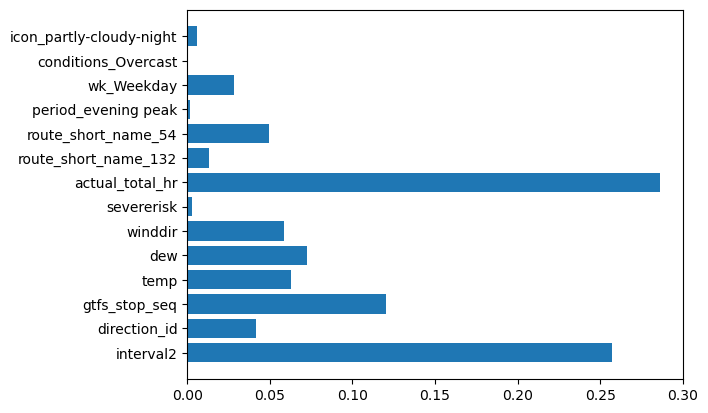

In [39]:
plt.barh(x.columns, reg.feature_importances_)

# Linear regression

In [40]:
from sklearn.linear_model import LinearRegression 
reg = LinearRegression()
reg.fit(X_train, Y_train)
y_pred = reg.predict(X_train)

# Model Evaluation
print('R^2:',metrics.r2_score(Y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_train, y_pred))*(len(Y_train)-1)/(len(Y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_train, y_pred))
print('MSE:',metrics.mean_squared_error(Y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_train, y_pred)))

R^2: 0.18015192091897447
Adjusted R^2: 0.17987403322995799
MAE: 7.956302259144674
MSE: 112.54111799052353
RMSE: 10.608539861381656


In [41]:
y_test_pred = reg.predict(X_test)

acc_rf = metrics.r2_score(Y_test, y_test_pred)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_test, y_test_pred))*(len(Y_test)-1)/(len(Y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(Y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_test, y_test_pred)))

R^2: 0.1659054601080543
Adjusted R^2: 0.16524550059870147
MAE: 8.016666578941363
MSE: 113.60181386550107
RMSE: 10.658415166688764


# lasso

In [42]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=0.001)
reg.fit(X_train, Y_train)
y_pred = reg.predict(X_train)

# Model Evaluation
print('R^2:',metrics.r2_score(Y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_train, y_pred))*(len(Y_train)-1)/(len(Y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_train, y_pred))
print('MSE:',metrics.mean_squared_error(Y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_train, y_pred)))

R^2: 0.18015177787892234
Adjusted R^2: 0.17987389014142252
MAE: 7.956183285324297
MSE: 112.54113762573132
RMSE: 10.608540786825081


In [43]:
y_test_pred = reg.predict(X_test)

acc_rf = metrics.r2_score(Y_test, y_test_pred)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_test, y_test_pred))*(len(Y_test)-1)/(len(Y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(Y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_test, y_test_pred)))

R^2: 0.1659178036364084
Adjusted R^2: 0.16525785389360914
MAE: 8.016536488856088
MSE: 113.60013270450139
RMSE: 10.658336300966553


# Ridge

In [44]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

reg = Ridge(alpha=0.01)
reg.fit(X_train, Y_train)
y_pred = reg.predict(X_train)

# Model Evaluation
print('R^2:',metrics.r2_score(Y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_train, y_pred))*(len(Y_train)-1)/(len(Y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_train, y_pred))
print('MSE:',metrics.mean_squared_error(Y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_train, y_pred)))

R^2: 0.1801519209189647
Adjusted R^2: 0.17987403322994833
MAE: 7.956302255613817
MSE: 112.54111799052488
RMSE: 10.60853986138172


In [45]:
y_test_pred = reg.predict(X_test)

acc_rf = metrics.r2_score(Y_test, y_test_pred)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(Y_test, y_test_pred))*(len(Y_test)-1)/(len(Y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(Y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(Y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_test, y_test_pred)))

R^2: 0.16590546472621204
Adjusted R^2: 0.1652455052205133
MAE: 8.016666561068668
MSE: 113.60181323651831
RMSE: 10.658415137182372


In [147]:
data2.to_csv('feature engineering3.csv')

In [146]:
data2.describe()

,interval2,direction_id,gtfs_stop_seq,sched_adherence_min,temp,dew,winddir,severerisk,actual_total_hr,route_short_name_132,route_short_name_54,period_evening peak,wk_Weekday,conditions_Overcast,icon_partly-cloudy-night
count,59028.000000,59028.000000,59028.000000,59028.000000,59028.000000,59028.000000,59028.000000,59028.000000,59028.000000,59028.000000,59028.000000,59028.000000,59028.000000,59028.000000,59028.000000
mean,33.106616,0.507979,45.772040,10.168274,79.266009,64.672244,163.425053,11.176052,13.851064,0.008233,0.428017,0.242055,0.693095,0.000254,0.104442
std,24.412445,0.499941,27.541813,11.702932,5.806937,3.324118,76.287218,4.705137,4.994220,0.090364,0.494796,0.428331,0.461214,0.015939,0.305836
min,0.000000,0.000000,1.000000,-18.681183,63.600000,56.800000,0.000000,10.000000,0.040278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.933333,0.000000,22.000000,1.834025,75.800000,62.400000,131.000000,10.000000,9.382361,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.383333,1.000000,44.000000,6.434042,80.600000,64.300000,155.000000,10.000000,14.017222,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,44.616667,1.000000,67.000000,14.848129,83.500000,66.900000,181.000000,10.000000,17.879306,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,193.933333,1.000000,108.000000,69.382400,87.800000,72.600000,360.000000,30.000000,23.999722,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [155]:
data2['icon_partly-cloudy-night'].value_counts()

0    52863
1     6165
Name: icon_partly-cloudy-night, dtype: int64

In [145]:
data2.shape

(59028, 15)